## Pipeline de Dados: UNSW-NB15 - Modelagem

Este notebook faz parte do projeto avaliativo da disciplina de Tópicos Computacionais em Ciência de Dados. O intuito deste projeto é realizar um Pipeline completo de dados, indo do carregamento dos dados até a avaliação dos resultados de modelagem dos dataset do **UNSW-BN15**.

Este notebook é responsável pela modelagem dos dados.

Para esse Pipeline se adotou os dados de treino e teste disponibilizado repósitorio, que pode ser acessado neste [link aqui](https://research.unsw.edu.au/projects/unsw-nb15-dataset).

### Sumário
1. Importações e Funções
2. Leitura dos dados
3. Pré-Processamento
4. Modelagem
5. Avaliação dos Resultados

**Desenvolvido por**
- Yago Aquino
- yagopacheco.34@gmail.com

## 1. Importações e Funções

Nesta seção vamos realizar a importações das bibliotecas e funções usadas ao longo do EDA.

In [1]:
import os
import re
import warnings
import zipfile

import numpy as np
import pandas as pd

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px

from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, classification_report, precision_recall_fscore_support

import lightgbm as lgb
import shap

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.6f}'.format)
warnings.filterwarnings('ignore')

# Se for rodar local no jupyter ou vscode
# import plotly.io as pio
# import plotly.offline as pyo
# pio.renderers.default = "notebook"
# pyo.init_notebook_mode(connected=True)

### 1.1 Funções

In [2]:
def remocao_colunas_corr(df, target_col, corr_threshold=0.9, target_corr_range=(-0.1, 0.1), method='spearman'):
  features = df.drop(columns=[target_col])
  target = df[target_col]

  corr_matrix = features.corr(method=method).abs()
  target_corr = features.corrwith(target, method=method).abs()

  upper_tri = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
  high_corr_pairs = np.where((corr_matrix.values > corr_threshold) & upper_tri)

  columns_to_remove = set()
  removal_map = {}  # Mapear qual coluna foi removida por causa de qual

  for i, j in zip(high_corr_pairs[0], high_corr_pairs[1]):
      col_i = corr_matrix.columns[i]
      col_j = corr_matrix.columns[j]

      corr_i_target = target_corr[col_i]
      corr_j_target = target_corr[col_j]

      if target_corr_range[0] <= corr_i_target <= target_corr_range[1]:
          columns_to_remove.add(col_i)
          if col_i not in removal_map:
              removal_map[col_i] = []
          removal_map[col_i].append((col_j, corr_matrix.loc[col_i, col_j]))
      elif target_corr_range[0] <= corr_j_target <= target_corr_range[1]:
          columns_to_remove.add(col_j)
          if col_j not in removal_map:
              removal_map[col_j] = []
          removal_map[col_j].append((col_i, corr_matrix.loc[col_i, col_j]))
      elif corr_i_target < corr_j_target:
          columns_to_remove.add(col_i)
          if col_i not in removal_map:
              removal_map[col_i] = []
          removal_map[col_i].append((col_j, corr_matrix.loc[col_i, col_j]))
      else:
          columns_to_remove.add(col_j)
          if col_j not in removal_map:
              removal_map[col_j] = []
          removal_map[col_j].append((col_i, corr_matrix.loc[col_i, col_j]))

  print(f"Colunas removidas: {len(columns_to_remove)}")

  return list(columns_to_remove), removal_map


def apply_pca_reduction(df, target_col, variance_threshold=0.95, n_components=None):
  X = df.drop(columns=[target_col])
  y = df[target_col]

  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  if n_components is None:
      pca_temp = PCA()
      pca_temp.fit(X_scaled)

      cumsum_var = np.cumsum(pca_temp.explained_variance_ratio_)
      n_components = np.argmax(cumsum_var >= variance_threshold) + 1

      print(f"Componentes necessários para {variance_threshold*100}% variância: {n_components}")

  pca = PCA(n_components=n_components)
  X_pca = pca.fit_transform(X_scaled)

  pca_columns = [f'PC{i+1}' for i in range(n_components)]
  df_pca = pd.DataFrame(X_pca, columns=pca_columns, index=df.index)

  df_pca[target_col] = y

  print(f"Redução: {X.shape[1]} features para {n_components} componentes")
  print(f"Variância explicada: {pca.explained_variance_ratio_.sum():.4f}")

  return df_pca, pca, scaler


def detalhe_resultados(y_true, y_pred, y_proba=None, dataset_name="Teste",
                      X_shape=None, class_names=['Normal', 'Ataque']):

  print(f"RESULTADOS DO {dataset_name}:")
  print("=" * 80)

  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)

  roc_auc = None
  if y_proba is not None:
      roc_auc = roc_auc_score(y_true, y_proba)
      print(f"{'ROC AUC': <10}: {roc_auc:.4f}")

  print(f"{'ACCURACY': <10}: {accuracy:.4f}")
  print(f"{'PRECISION': <10}: {precision:.4f}")
  print(f"{'RECALL': <10}: {recall:.4f}")
  print(f"{'F1': <10}: {f1:.4f}")

  print("\n" + "=" * 80)

  unique, counts = np.unique(y_true, return_counts=True)
  class_dist = dict(zip(unique, counts))
  print(f"Distribuição das classes: {class_dist}")

  if X_shape is not None:
      print(f"- Número de features: {X_shape[1]}")
      print(f"- Número de amostras: {X_shape[0]}")

  print("\n" + "=" * 30)
  print("RELATÓRIO DETALHADO POR CLASSE:")
  print("=" * 30)
  print(classification_report(y_true, y_pred, target_names=class_names))

  return {
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1': f1,
      'roc_auc': roc_auc
  }


def comparacao_cv_test(cv_scores, test_metrics, verbose=True):
  if verbose:
      print("COMPARAÇÃO: Validação Cruza vs Teste")

  comparison = {}
  metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

  print(f"{'MÉTRICA':12} | {'CV (MÉDIA±2σ)':20} | {'TESTE':10} | {'DIFERENÇA':12}")
  print("-" * 65)

  for metric in metrics:
      cv_key = f'test_{metric}'

      if cv_key in cv_scores and metric in test_metrics and test_metrics[metric] is not None:
          cv_mean = cv_scores[cv_key].mean()
          cv_std = cv_scores[cv_key].std()
          test_value = test_metrics[metric]

          diff = test_value - cv_mean
          diff_pct = (diff / cv_mean * 100) if cv_mean != 0 else 0

          diff_str = f"{diff:+.4f}"

          print(f"{metric.upper():12} | {cv_mean:.4f}±{cv_std*2:.4f}      | {test_value:.4f}    | {diff_str}")

          comparison[metric] = {
              'cv_mean': cv_mean,
              'cv_std': cv_std,
              'test_value': test_value,
              'difference': diff,
              'difference_pct': diff_pct
          }

  print("-" * 65)

  print("\nANÁLISE:")

  # Aqui é para verificar se o teste está consistente com CV
  significant_drops = []
  for metric, data in comparison.items():
      if abs(data['difference_pct']) > 10:
          direction = "maior" if data['difference'] > 0 else "menor"
          significant_drops.append(f"- {metric.upper()}: {direction} ({data['difference_pct']:+.1f}%)")

  if significant_drops:
      print("Diferenças significativas encontradas:")
      for drop in significant_drops:
          print(drop)
  else:
      print("Resultados consistentes entre CV e teste final")

  if 'accuracy' in comparison:
      acc_diff = comparison['accuracy']['difference_pct']
      if acc_diff < -10:
          print("Possível overfitting: teste significativamente pior que CV")
      elif acc_diff > 10:
          print("Teste melhor que CV: verificar vazamento de dados")
      else:
          print("Performance estável entre CV e teste")

  return comparison


def analise_performance_classe(y_true, y_pred, class_names=['Normal', 'Ataque']):
  print(f"\nANÁLISE POR CLASSE:")
  print("=" * 40)

  cm = confusion_matrix(y_true, y_pred)
  print("Matriz de Confusão:")
  print(f"              Pred")
  print(f"Real    {class_names[0]:>8} {class_names[1]:>8}")
  for i, class_name in enumerate(class_names):
      print(f"{class_name:>8}", end="")
      for j in range(len(class_names)):
          print(f"{cm[i,j]:>8}", end="")
      print()

  # Métricas por classe
  precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)

  print(f"\nMétricas por Classe:")
  print(f"{'Classe':>10} | {'Precision':>9} | {'Recall':>9} | {'F1-Score':>9} | {'Support':>8}")
  print("-" * 60)

  for i, class_name in enumerate(class_names):
      print(f"{class_name:>10} | {precision[i]:>9.4f} | {recall[i]:>9.4f} | {f1[i]:>9.4f} | {support[i]:>8}")

  tn, fp, fn, tp = cm.ravel()

  print(f"\nMÉTRICAS ESPECÍFICAS:")
  print(f"- True Positives:  {tp:,}")
  print(f"- True Negatives:  {tn:,}")
  print(f"- False Positives: {fp:,}")
  print(f"- False Negatives: {fn:,}")
  print(f"- Taxa de Falsos Positivos: {fp / (fp + tn)*100:.2f}%")
  print(f"- Taxa de Falsos Negativos: {fn / (fn + tp)*100:.2f}%")


def plot_por_classe(df, features, target_col='label'):
  n_features = len(features)
  n_cols = 2
  n_rows = (n_features + 1) // 2

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
  if n_rows == 1:
      axes = axes.reshape(1, -1)

  for i, feature in enumerate(features):
      if feature not in df.columns:
          continue

      row = i // n_cols
      col = i % n_cols
      ax = axes[row, col]

      normal_data = df[df[target_col] == 0][feature]
      attack_data = df[df[target_col] == 1][feature]

      ax.hist(normal_data, bins=30, alpha=0.7, label='Benigno',
              color='#2E8B57', density=True)
      ax.hist(attack_data, bins=30, alpha=0.7, label='Maligno',
              color='#DC143C', density=True)

      ax.set_title(f'Distribuição: {feature}')
      ax.set_xlabel(feature)
      ax.set_ylabel('Densidade')
      ax.legend()
      ax.grid(True, alpha=0.3)

  for i in range(len(features), n_rows * n_cols):
      row = i // n_cols
      col = i % n_cols
      fig.delaxes(axes[row, col])

  plt.tight_layout()
  plt.show()


def plot_feature_importance(model, feature_names, top_n=10):
  importance_df = pd.DataFrame({
      'feature': feature_names,
      'importance': model.feature_importances_
  }).sort_values('importance', ascending=False).head(top_n)

  plt.figure(figsize=(10, 6))

  ax = sns.barplot(data=importance_df,
                    y='feature',
                    x='importance',
                    palette='Blues_r',
                    alpha=0.8,
                    edgecolor='black')

  sns.despine(top=True, right=True)

  plt.xlabel('Importância da Feature')
  plt.title(f'Top {top_n} Features Mais Importantes', fontweight='bold', pad=20)

  for i, (_, row) in enumerate(importance_df.iterrows()):
      plt.text(row['importance'] + max(importance_df['importance'])*0.01, i,
              f'{row["importance"]:.0f}', va='center', fontweight='bold')

  plt.tight_layout()
  plt.show()

  return importance_df


def box_plot(df, x, y, xlab=None, ylab=None, figsize=(12,6), ylim=None, hue=None, palette=None, color='lightskyblue', x_rotation=None):

  plt.figure(figsize=figsize)

  boxplot_params = {
      'data': df,
      'x': x,
      'y': y,
      'flierprops': {
          'marker': 'o',
          'markersize': 4
      }
  }

  if hue is not None:
      boxplot_params['hue'] = hue

      if palette is not None:
          boxplot_params['palette'] = palette
  else:
      boxplot_params['color'] = color

  ax = sns.boxplot(**boxplot_params)

  if ylim:
      plt.ylim(ylim)

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  plt.suptitle('')
  plt.xlabel(xlab)
  plt.ylabel(ylab)

  plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))

  if x_rotation is not None:
      plt.xticks(rotation=x_rotation)

      if x_rotation >= 45:
          plt.xticks(rotation=x_rotation, ha='right')

  if hue is not None:
      plt.legend(title=hue)

  plt.show()

## 2. Leitura dos dados

Nesta seção vamos realizar a leitura dos dados.

In [3]:
# Extração dos arquivos
with zipfile.ZipFile('/content/unsw_data.zip', 'r') as zip_file:
    arquivos = zip_file.namelist()
    print("Arquivos no ZIP:", arquivos, '\n')

    df_test = pd.read_csv(zip_file.open(arquivos[1]))
    df = pd.read_csv(zip_file.open(arquivos[2]))

print(f"\nTreino: {df.shape}")
display(df.head())

print(f"\nTeste: {df_test.shape}")
display(df_test.head())

Arquivos no ZIP: ['unsw_data/', 'unsw_data/UNSW_NB15_testing-set.csv', 'unsw_data/UNSW_NB15_training-set.csv'] 


Treino: (175341, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0



Teste: (82332, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,254,0,180363632.000000,0.000000,0,0,0.011000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,254,0,881000000.000000,0.000000,0,0,0.008000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,254,0,854400000.000000,0.000000,0,0,0.005000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,254,0,600000000.000000,0.000000,0,0,0.006000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,254,0,850400000.000000,0.000000,0,0,0.010000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0


In [4]:
arquivos[2]


'unsw_data/UNSW_NB15_training-set.csv'

## 3. Pré-Processamento

Nesta seção vamos aplicar o pré-processamento dos dados para fazer o seu uso no modelo. Inicialmente vamos fazer a remoção de colunas altamente relacionadas entre sí e com relação 0 com a coluna alvo.

Pensou em aplicar um PCA, entretanto se tem a perda de interpretabilidade, o que não é algo que buscamos.

In [5]:
# Removendo as categoricas (poderiamos aplicar a transformação e incluir ela aqui também, mas quero manter elas nos dados)
drop_corr = [
    'id', 'is_ftp_login', 'is_sm_ips_ports',
    'proto', 'service', 'state', 'attack_cat',
]

colunas_to_remove_corr, map_corr = remocao_colunas_corr(df.drop(drop_corr, axis=1), 'label', corr_threshold=0.91) # Coluna indicadas para remoção por meio da correlação
colunas_to_remove_corr

Colunas removidas: 21


['dpkts',
 'rate',
 'swin',
 'dload',
 'dloss',
 'synack',
 'sinpkt',
 'ackdat',
 'dwin',
 'dttl',
 'spkts',
 'sjit',
 'djit',
 'stcpb',
 'dtcpb',
 'dbytes',
 'ct_srv_src',
 'sloss',
 'dmean',
 'tcprtt',
 'trans_depth']

Colunas removidas:
```
['dmean',
 'sloss',
 'ackdat',
 'dttl',
 'tcprtt',
 'dloss',
 'dtcpb',
 'sinpkt',
 'sload',
 'trans_depth',
 'stcpb',
 'djit',
 'synack',
 'dwin',
 'spkts',
 'ct_state_ttl',
 'dpkts',
 'dbytes']
```

A seleção de features priorizou a aplicabilidade em ambientes reais de produção. Features TTL (sttl, dttl, ct_state_ttl) foram removidas pois frequentemente não estarão disponíveis em logs de rede corporativos. As features de agregação temporal (ct_*) foram excluídas por requererem informações futuras não disponíveis em detecção em tempo real, essa informação pode ser vista na tabela de features disponibilizada pela UNSW e também se encontra no git, além disso a construção dessa feature é informada pelo auto no seu trabalho `UNSW-NB15: a comprehensive data set for network intrusion detection systems`.

In [6]:
features_remove = [
    'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
    'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
    'sttl', 'dttl', 'ct_state_ttl', 'attack_cat', 'ct_flw_http_mthd',
    'ct_ftp_cmd'
]

problematic_features = [
    'response_body_len',  # Requer resposta completa - não disponível em tempo real
    'dinpkt',             # Inter-packet delay - pode precisar de agregação temporal
    'sjit',               # Source jitter - pode precisar de múltiplos pacotes
    'dload'               # Pode precisar de agregação temporal
]

features_remove = features_remove + problematic_features
features_remove

['ct_srv_src',
 'ct_srv_dst',
 'ct_dst_ltm',
 'ct_src_ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'sttl',
 'dttl',
 'ct_state_ttl',
 'attack_cat',
 'ct_flw_http_mthd',
 'ct_ftp_cmd',
 'response_body_len',
 'dinpkt',
 'sjit',
 'dload']

### 3.1 Dados de treino

In [7]:
df_modi = df.drop(colunas_to_remove_corr + features_remove, axis=1).copy()

print(df_modi.shape)
df_modi.head()

(175341, 11)


,id,dur,proto,service,state,sbytes,sload,smean,is_ftp_login,is_sm_ips_ports,label
0,1,0.121478,tcp,-,FIN,258,14158.942380,43,0,0,0
1,2,0.649902,tcp,-,FIN,734,8395.112305,52,0,0,0
2,3,1.623129,tcp,-,FIN,364,1572.271851,46,0,0,0
3,4,1.681642,tcp,ftp,FIN,628,2740.178955,52,1,0,0
4,5,0.449454,tcp,-,FIN,534,8561.499023,53,0,0,0


In [8]:
# Reduzindo as categorias das colunas
protocolos_principais = ['tcp', 'udp', 'unas', 'arp', 'ospf']
servicos_principais = ['-', 'dns', 'http', 'ftp-data', 'smtp', 'ftp', 'ssh']
state_principais = ['FIN', 'INT', 'CON', 'REQ', 'RST', ]

df_modi['proto_agg'] = df_modi['proto'].where(df_modi['proto'].isin(protocolos_principais), 'outro_proto')
df_modi['service_agg'] = df_modi['service'].where(df_modi['service'].isin(servicos_principais), 'outro_service')
df_modi['state_agg'] = df_modi['state'].where(df_modi['state'].isin(state_principais), 'outro_state')

In [9]:
# df_modi[df_modi['service_agg'] == 'outro_service']['service'].unique()
# df_modi[df_modi['state_agg'] == 'outro_state']['state'].unique()
df_modi = df_modi.drop(['proto', 'service', 'state'], axis=1)

In [10]:
colunas_one_hot = ['proto_agg', 'service_agg', 'state_agg']

encoder = OneHotEncoder(
    sparse_output=False,
    drop='first',
    handle_unknown='ignore'
)

X_categorical_encoded = encoder.fit_transform(df_modi[colunas_one_hot])

# Manter os nomes
feature_names = encoder.get_feature_names_out(colunas_one_hot)
print("\nFeatures criadas:", feature_names)

# Convertendo as mudanças para DF
df_encoded = pd.DataFrame(
    X_categorical_encoded.astype('int8'),
    columns=feature_names,
    index=df_modi.index
)

# Fazendo a concatenação do meu DF
numeric_cols = df_modi.select_dtypes(include=[np.number]).columns
df_final = pd.concat([df_modi[numeric_cols], df_encoded], axis=1)

print("\n", df_final.shape)
df_final.head()


Features criadas: ['proto_agg_ospf' 'proto_agg_outro_proto' 'proto_agg_tcp' 'proto_agg_udp'
 'proto_agg_unas' 'service_agg_dns' 'service_agg_ftp'
 'service_agg_ftp-data' 'service_agg_http' 'service_agg_outro_service'
 'service_agg_smtp' 'service_agg_ssh' 'state_agg_FIN' 'state_agg_INT'
 'state_agg_REQ' 'state_agg_RST' 'state_agg_outro_state']

 (175341, 25)


,id,dur,sbytes,sload,smean,is_ftp_login,is_sm_ips_ports,label,proto_agg_ospf,proto_agg_outro_proto,proto_agg_tcp,proto_agg_udp,proto_agg_unas,service_agg_dns,service_agg_ftp,service_agg_ftp-data,service_agg_http,service_agg_outro_service,service_agg_smtp,service_agg_ssh,state_agg_FIN,state_agg_INT,state_agg_REQ,state_agg_RST,state_agg_outro_state
0,1,0.121478,258,14158.942380,43,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2,0.649902,734,8395.112305,52,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,3,1.623129,364,1572.271851,46,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,1.681642,628,2740.178955,52,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,5,0.449454,534,8561.499023,53,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [11]:
X = df_final.drop(['label', 'id'], axis=1)
y = df_final['label']

X.shape, y.shape

((175341, 23), (175341,))

### 3.2 Dados de teste

In [12]:
df_modi_test = df_test.drop(colunas_to_remove_corr + features_remove, axis=1).copy()

print(df_modi_test.shape)
df_modi_test.head()

(82332, 11)


,id,dur,proto,service,state,sbytes,sload,smean,is_ftp_login,is_sm_ips_ports,label
0,1,0.000011,udp,-,INT,496,180363632.000000,248,0,0,0
1,2,0.000008,udp,-,INT,1762,881000000.000000,881,0,0,0
2,3,0.000005,udp,-,INT,1068,854400000.000000,534,0,0,0
3,4,0.000006,udp,-,INT,900,600000000.000000,450,0,0,0
4,5,0.000010,udp,-,INT,2126,850400000.000000,1063,0,0,0


In [13]:
df_modi_test['proto_agg'] = df_modi_test['proto'].where(df_modi_test['proto'].isin(protocolos_principais), 'outro_proto')
df_modi_test['service_agg'] = df_modi_test['service'].where(df_modi_test['service'].isin(servicos_principais), 'outro_service')
df_modi_test['state_agg'] = df_modi_test['state'].where(df_modi_test['state'].isin(state_principais), 'outro_state')

df_modi_test = df_modi_test.drop(['proto', 'service', 'state'], axis=1)

X_categorical_encoded = encoder.transform(df_modi_test[colunas_one_hot]) # Já treinamos, não precisamos mais do fit, visto que temos as mesmas colunas e classe

feature_names = encoder.get_feature_names_out(colunas_one_hot)
print("\nFeatures criadas:", feature_names)

df_encoded = pd.DataFrame(
    X_categorical_encoded.astype('int8'),
    columns=feature_names,
    index=df_modi_test.index
)

numeric_cols = df_modi_test.select_dtypes(include=[np.number]).columns
df_final_test = pd.concat([df_modi_test[numeric_cols], df_encoded], axis=1)

print("\n", df_final_test.shape)
df_final_test.head()


Features criadas: ['proto_agg_ospf' 'proto_agg_outro_proto' 'proto_agg_tcp' 'proto_agg_udp'
 'proto_agg_unas' 'service_agg_dns' 'service_agg_ftp'
 'service_agg_ftp-data' 'service_agg_http' 'service_agg_outro_service'
 'service_agg_smtp' 'service_agg_ssh' 'state_agg_FIN' 'state_agg_INT'
 'state_agg_REQ' 'state_agg_RST' 'state_agg_outro_state']

 (82332, 25)


,id,dur,sbytes,sload,smean,is_ftp_login,is_sm_ips_ports,label,proto_agg_ospf,proto_agg_outro_proto,proto_agg_tcp,proto_agg_udp,proto_agg_unas,service_agg_dns,service_agg_ftp,service_agg_ftp-data,service_agg_http,service_agg_outro_service,service_agg_smtp,service_agg_ssh,state_agg_FIN,state_agg_INT,state_agg_REQ,state_agg_RST,state_agg_outro_state
0,1,0.000011,496,180363632.000000,248,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2,0.000008,1762,881000000.000000,881,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,3,0.000005,1068,854400000.000000,534,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,4,0.000006,900,600000000.000000,450,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,5,0.000010,2126,850400000.000000,1063,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [14]:
X_test = df_final_test.drop(['label', 'id'], axis=1)
y_test = df_final_test['label']

X_test.shape, y_test.shape

((82332, 23), (82332,))

## 4. Modelagem

Nesta seção é aplicada a modelagem dos dados. Optou-se pelo modelo LightGBM (LGBM), que segue o padrão dos modelos baseados em árvores de decisão, mas com implementações otimizadas que o tornam uma escolha superior para muitas aplicações.

O LightGBM é um framework de gradient boosting desenvolvido pela Microsoft que oferece velocidade superior (até 10x mais rápido), menor uso de memória e maior precisão comparado a outros algoritmos similares. Para dados desbalanceados, o LGBM apresenta vantagens específicas como parâmetros nativos de balanceamento (is_unbalance=True, class_weight='balanced'), otimização focada em métricas robustas (AUC-ROC, F1-Score) e crescimento leaf-wise das árvores que identifica melhor as regiões mais informativas dos dados.

Essas características tornam o LightGBM especialmente adequado para problemas de classificação com classes desproporcionais, oferecendo tanto eficiência computacional quanto performance preditiva superior.

Referência: [LightGBM Documentation](https://lightgbm.readthedocs.io/en/stable/)

In [15]:
model_lgb = lgb.LGBMClassifier(
    objective='binary',
    is_unbalance=True,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    num_leaves=31,
    min_child_samples=20,
    random_state=42,
    verbose=-1,
    n_jobs=-1
)

In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy'
}

scores = cross_validate(
    model_lgb,
    X, y,
    cv=cv,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

In [17]:
# Visualização simples dos resultados de treino
print("RESULTADOS DA VALIDAÇÃO CRUZADA:")
print("=" * 80)

for metric, values in scores.items():
    if metric.startswith('test_'):
        metric_name = metric[5:].upper()  # Remove 'test_' do nome
        mean_score = values.mean()
        std_score = values.std()

        print(f"{metric_name:10}: {mean_score:.4f} (+/- {std_score * 2:.4f})")

print("\n" + "=" * 80)

recall_scores = scores['test_recall']
print(f"RECALL por fold: {recall_scores}")
print(f"RECALL médio: {recall_scores.mean():.4f}")

print(f"\nInformações do modelo:")
print(f"- Número de features: {X.shape[1]}")
print(f"- Número de amostras: {X.shape[0]}")
print(f"- Balanceamento das classes: {y.value_counts().to_dict()}")

RESULTADOS DA VALIDAÇÃO CRUZADA:
RECALL    : 0.9354 (+/- 0.0054)
PRECISION : 0.9608 (+/- 0.0024)
F1        : 0.9479 (+/- 0.0027)
ROC_AUC   : 0.9863 (+/- 0.0012)
ACCURACY  : 0.9300 (+/- 0.0035)

RECALL por fold: [0.9315849  0.93761522 0.9392911  0.93443104 0.93417965]
RECALL médio: 0.9354

Informações do modelo:
- Número de features: 23
- Número de amostras: 175341
- Balanceamento das classes: {1: 119341, 0: 56000}


In [18]:
model_lgb.fit(X, y)
prev = model_lgb.predict(X_test)

y_proba_test = model_lgb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, prev))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85     37000
           1       0.86      0.93      0.89     45332

    accuracy                           0.87     82332
   macro avg       0.88      0.87      0.87     82332
weighted avg       0.88      0.87      0.87     82332



### 4.1 Avaliação de resultados

Nesta seção serpa feita análises dos resultados a fim compreender pontos de melhoria no modelo.

In [19]:
print("\n")
test_metrics = detalhe_resultados(
    y_test, prev, y_proba_test,
    dataset_name="Teste",
    X_shape=X_test.shape,
    class_names=['Beningo', 'Malicioso']
)

comparison = comparacao_cv_test(scores, test_metrics)



RESULTADOS DO Teste:
ROC AUC   : 0.9690
ACCURACY  : 0.8735
PRECISION : 0.8561
RECALL    : 0.9260
F1        : 0.8896

Distribuição das classes: {np.int64(0): np.int64(37000), np.int64(1): np.int64(45332)}
- Número de features: 23
- Número de amostras: 82332

RELATÓRIO DETALHADO POR CLASSE:
              precision    recall  f1-score   support

     Beningo       0.90      0.81      0.85     37000
   Malicioso       0.86      0.93      0.89     45332

    accuracy                           0.87     82332
   macro avg       0.88      0.87      0.87     82332
weighted avg       0.88      0.87      0.87     82332

COMPARAÇÃO: Validação Cruza vs Teste
MÉTRICA      | CV (MÉDIA±2σ)        | TESTE      | DIFERENÇA   
-----------------------------------------------------------------
ACCURACY     | 0.9300±0.0035      | 0.8735    | -0.0565
PRECISION    | 0.9608±0.0024      | 0.8561    | -0.1047
RECALL       | 0.9354±0.0054      | 0.9260    | -0.0095
F1           | 0.9479±0.0027      | 0.8896    

In [20]:
analise_performance_classe(y_test, prev, ['Beningo', 'Malicioso'])


ANÁLISE POR CLASSE:
Matriz de Confusão:
              Pred
Real     Beningo Malicioso
 Beningo   29942    7058
Malicioso    3356   41976

Métricas por Classe:
    Classe | Precision |    Recall |  F1-Score |  Support
------------------------------------------------------------
   Beningo |    0.8992 |    0.8092 |    0.8519 |    37000
 Malicioso |    0.8561 |    0.9260 |    0.8896 |    45332

MÉTRICAS ESPECÍFICAS:
- True Positives:  41,976
- True Negatives:  29,942
- False Positives: 7,058
- False Negatives: 3,356
- Taxa de Falsos Positivos: 19.08%
- Taxa de Falsos Negativos: 7.40%


In [21]:
print(f"\nINFORMAÇÕES ADICIONAIS:")
print(f"- Algoritmo: LightGBM")
print(f"- Features utilizadas: {X.shape[1]}")
print(f"- Amostras treino: {X.shape[0]:,}")
print(f"- Amostras teste: {X_test.shape[0]:,}")
print(f"- Features removidas {df.shape[1] - X.shape[1]}")

if hasattr(model_lgb, 'feature_importances_'):
    print(f"\nTOP 5 FEATURES MAIS IMPORTANTES:")
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model_lgb.feature_importances_
    }).sort_values('importance', ascending=False)

    for i, (_, row) in enumerate(feature_importance.head(5).iterrows()):
        print(f"{i+1}. {row['feature']}: {row['importance']:.4f}")


INFORMAÇÕES ADICIONAIS:
- Algoritmo: LightGBM
- Features utilizadas: 23
- Amostras treino: 175,341
- Amostras teste: 82,332
- Features removidas 22

TOP 5 FEATURES MAIS IMPORTANTES:
1. sbytes: 696.0000
2. smean: 582.0000
3. dur: 485.0000
4. sload: 372.0000
5. state_agg_INT: 92.0000


**Pequena Conclusão**

Conseguimo verificar que a nossa classe 0, que representa o tráfego benigno tem os seus valores de precisão e recall mais baixo que da classe 1, de tráfego maligno. Isso já era esperado devido ao desbalanceamento das classes, mesmo utilizando o balanceamento utilizado pelo LGBM (que em teste passados que realizei se mostrou melhor que técnicas tradicionais da literatura) não trouxe uma solução 100%.

Outro ponto de reflexão aqui é confrme comentando nos artigos disponibilizados pelo autor é posível notar que certas features acabam trazendo data leakage para o modelo devido a forma como foram construídas.

### 4.2 Visualização dos resultados

Nesta seção será realziada visualizações a fim de compreender os resultados gerados pelo modelo.

In [22]:
# explainer = shap.TreeExplainer(model_lgb)
# shap_values = explainer.shap_values(X_test)

# shap.summary_plot(shap_values, X_test)

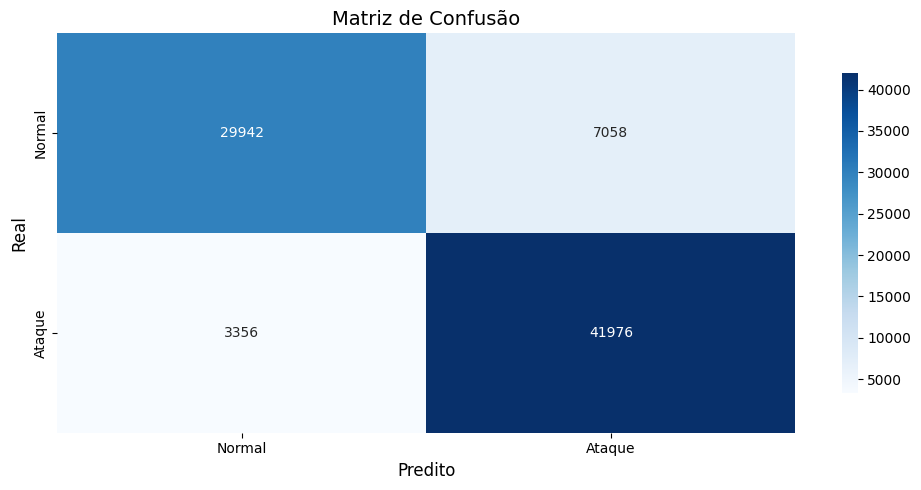

In [23]:
cm_test = confusion_matrix(y_test, prev)

plt.figure(figsize=(10, 5))

cmap = 'Blues'
fmt = 'd'

sns.heatmap(
    cm_test,
    annot=True,
    fmt=fmt,
    cmap=cmap,
    cbar_kws={'shrink': 0.8}
)

plt.title('Matriz de Confusão', fontsize=14)
plt.xlabel('Predito', fontsize=12)
plt.ylabel('Real', fontsize=12)

ax = plt.gca()
ax.set_xticklabels(['Normal', 'Ataque'])
ax.set_yticklabels(['Normal', 'Ataque'])

plt.tight_layout()
plt.show()

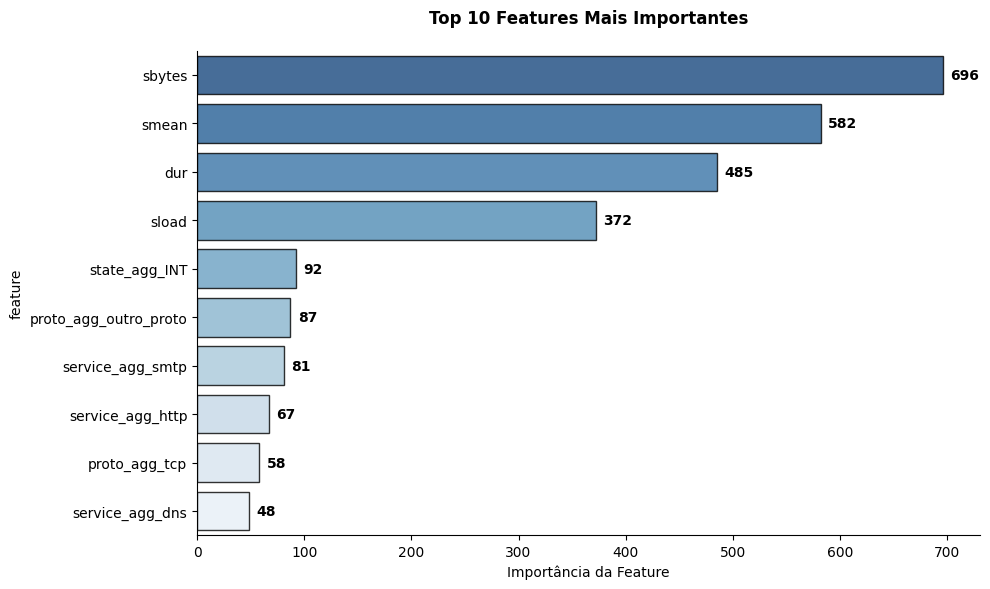

In [24]:
importance_df = plot_feature_importance(model_lgb, X.columns, top_n=10)

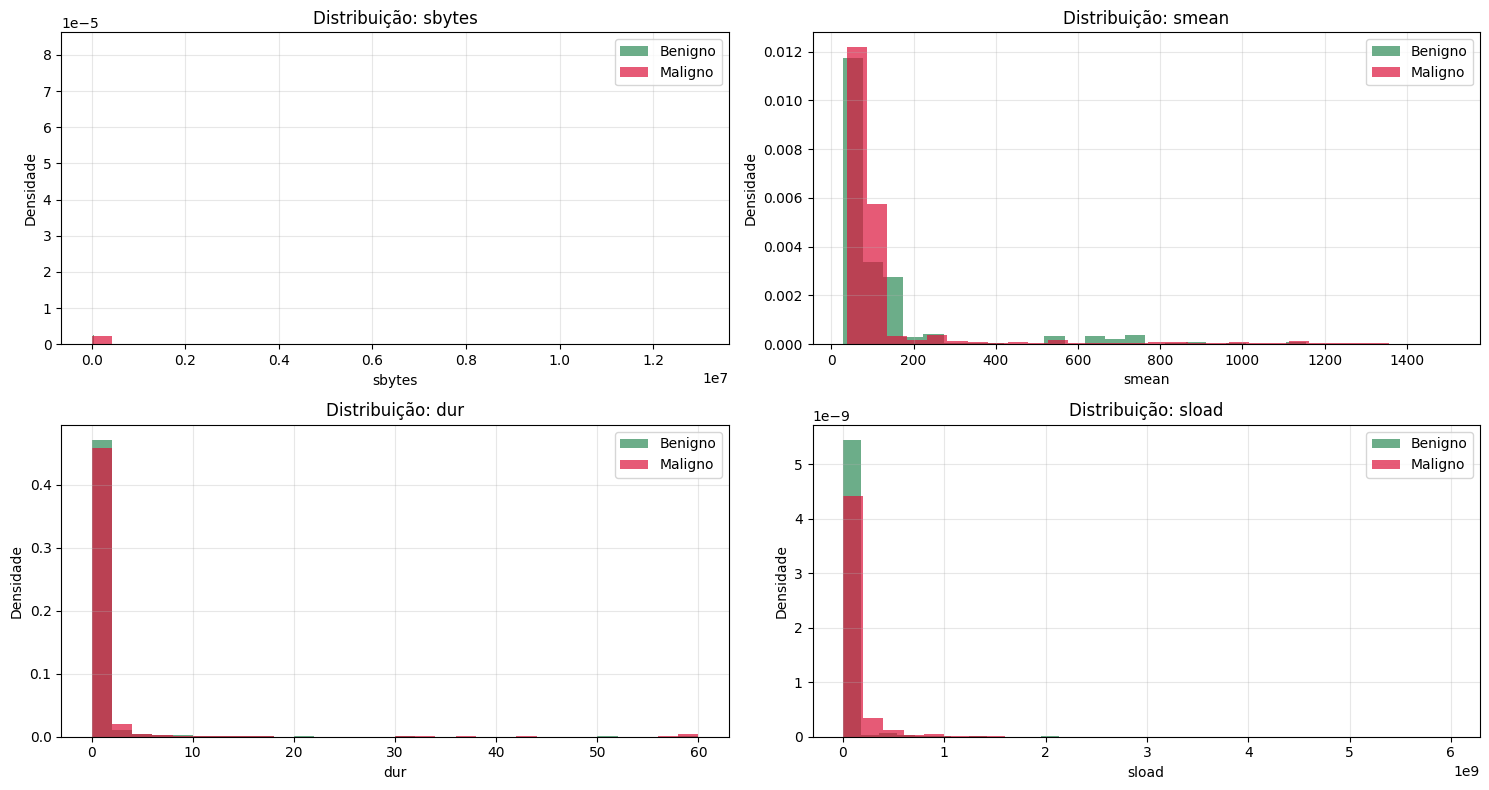

In [25]:
top_features = ['sbytes', 'smean', 'dur', 'sload']
plot_por_classe(df_final, top_features, 'label')

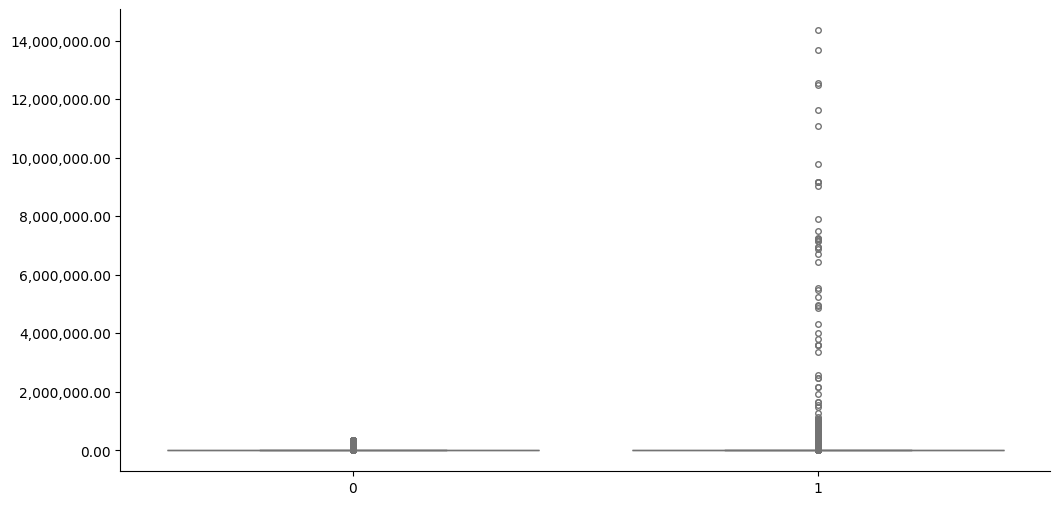

In [26]:
box_plot(
    df_test,
    x='label',
    y='sbytes',
    # hue='variable',
    xlab='',
    ylab='',
)

In [27]:
print(f"Mediana Benigno e Maligno: {df_test[df_test['label'] == 0]['sbytes'].median(), df_test[df_test['label'] == 1]['sbytes'].median()}")
print(f"Media Benigno e Maligno: {df_test[df_test['label'] == 0]['sbytes'].mean(), df_test[df_test['label'] == 1]['sbytes'].mean()}")

Mediana Benigno e Maligno: (974.0, 200.0)
Media Benigno e Maligno: (np.float64(4072.3773783783786), np.float64(11194.66346069002))


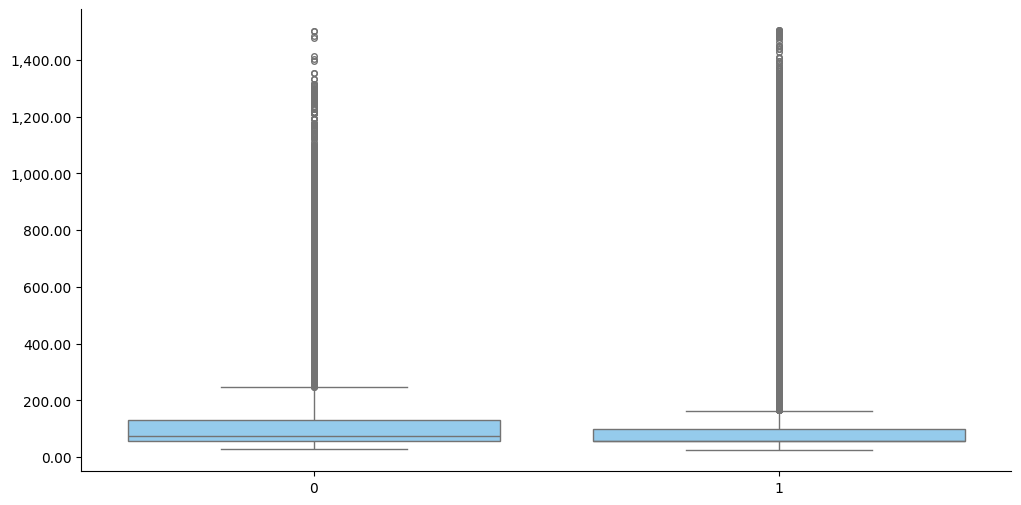

In [28]:
box_plot(
    df_test,
    x='label',
    y='smean',
    xlab='',
    ylab='',
)

In [29]:
print(f"Mediana Benigno e Maligno: {df_test[df_test['label'] == 0]['smean'].median(), df_test[df_test['label'] == 1]['smean'].median()}")
print(f"Media Benigno e Maligno: {df_test[df_test['label'] == 0]['smean'].mean(), df_test[df_test['label'] == 1]['smean'].mean()}")

Mediana Benigno e Maligno: (73.0, 57.0)
Media Benigno e Maligno: (np.float64(153.6381081081081), np.float64(128.01241948292596))


**Pequena Conclusão**

A matriz de confusáo é uma forma de validar os resultados que vimos na seção acima. Se observamos veremos que o maior gargalo dela é em classificar o trafego Benigno. Isso se deve ao desbalanceamento dos dados e a técnica ue usamos não ter sido tão efetiva.

Ao olhar a importância das features conseguimos notar que smean e sbytes são as mais relevantes para detecção de tráfego maligno e benigno. O que era esperado por essas colunas trazerem informações de fluxo de pacotes e os bytes trocados trocados no processo. Quando olhamos o boxplot dessas colunas verificamos alguns comportamentos interessantes. O sbytes para o tráfego maligno apresenta muitos outliers mas tem a mediana menor que o benigno e isso se deve ao tráfego maligno ter diversas formas de ataque. Ataques que tentam inviabilizar o sistema com grandes quantidades de dados e ataques que tentam enganar o sistema e roubar informações. Já para o `smean` tanto a média quanto a mediana são menores pelo fato de tentativas de ataques com pacotes pequenos, permitindo vários ataques e no fim sobrecarregando o sistema.

Um feature que ajudaria muito aqui seria verificar o tamanho do cabeçalho, uma estratégia que funcionou muito bem no conjunto de dados do IOT, porém aqui não temos as informações necessárias e para criar seria fazendo um proxy que poderia carregar incertezas e vieses ao modelo. Com isso, optou por não criar.

Por fim, olhando a distribuição das 5 melhores features, não vemos nada de diferente ou algum padrão que pudesse ajudar a análisar o tipo do trafego. Algo que vimos no nosso EDA inicial.